# Análisis de sentimiento político en la nube

Actualmente los tres proveedores principales de computación en la nube, incluidos servicios de Machine Learning, ofrecen un la posibilidad de analizar el sentimiento de un determinado texto. Se trata de un servicio, general y no contextualizado, a través del cual y a partir de un determinado texto, una puntación sobre la positividad o negatividad del mismo. Generalmente esta puntuación va desde 0 hasta 1. Los valores cercanos a 0 indican un sentimiento negativo, mientras que los cercanos a 1 reperesentan sentimientos positivos. Estos servicios son gratuitos para muestras de textos no muy elevadas y se realizan a través de una llamada API, previa identificación del usuario que hace las peticiones en el sistema.

En este artículo nos basamos en el estudio de cerca de 7000 tweeets de políticos de 7 partidos políticos diferentes, analizando sus sentimientos de acuerdo a los sistemas de Azure (Microsoft), GCP (Google) y AWS (Amazon). Una vez se obtinen los diferentes sentimientos de todos los mensajes se procede a su analisis e interpretación. 

Para entender la puntuación se muestran a continuación un mensaje positivo (Sentimiento 1), un mensaje neutro (Sentimiento 0.5) y un mensaje negativo (Sentimiento cercano 0. 

- Tweet positivo: *"¡Así os esperamos! #Barcelona, ciudad abierta, diversa, tolerante, cosmopolita, orgullosa, feminista #BusDelAmor 🚌💪🏼🌈😊"*
- Tweet negativo: *"La irresponsabilidad y dejación del @govern sigue pasando factura al desarrollo económico catalán. El triste cuanto peor mejor del procesismo"*
- Tweet neutro: *"Les etiquetes ambientals generalment intenten blanquejar pràctiques gens respectuoses amb el medi ambient. Un exemple, l'oxímoron turisme sostenible. "*

Evidentemente cada una de las nubes tiene sus algoritmos de cálculo y criterios de clasificación, por lo que pueden surgir diferencias de sentimiento dependiendo del proveedor que se utilice. Aunque en general y como se verá más adelante las tres nubes tienen sentimientos muy correlacionados se muestra a continuación un ejemplo cuyo sentimiento varía dependiendo del proveedor que se utilice: 

- Ejemplo de tweet con diferente sentimiento: *"La nostra obligació és escoltar i entendre el que demana Barcelona per donar-li la resposta adequada: projecte clar, compromís ferm, voluntat i credibilitat."*

En este caso Google otorga un sentimiento de 0.10, indicando un caracter marcadamente negativo, mientras que Azure le asigna un 0.82, indicando positivdad en el mensaje. 

Conviene destacar que los sintemas de asignación de una puntuacion de sentimiento trabajan con el lenguaje Español y que por lo tanto, todos los mensajes han sido traducidos previamente con la consecuente afectación a la intención original. 


In [30]:
## Cargando dependencias
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
ROOT_PATH = "/Users/lina/DataScience/Project/Yoga/"
PERSONAL_PATH = "Personal/Alvaro"
sys.path.append(os.path.join(ROOT_PATH, 'src'))
os.chdir(os.path.join(ROOT_PATH, PERSONAL_PATH))
sys.path.append(os.path.join(ROOT_PATH, PERSONAL_PATH))
TRAIN_FPATH = os.path.join(ROOT_PATH, "Data/train_traducido.csv")

#All imports goes here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;
from parties_classification import remove_tweets_with_non_identified_language
from parties_classification import add_text_clean_col_to_df
from parties_classification import get_sentiment_features_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
## Load data and Preprocess Data ##
train_df_tr = pd.read_csv(TRAIN_FPATH, delimiter=';')
train_df_tr = remove_tweets_with_non_identified_language(train_df_tr)
train_df_tr = add_text_clean_col_to_df(train_df_tr)
  
train_df_sentiment = get_sentiment_features_df(ROOT_PATH, train_df_tr, str='train') # load sentiment
train_df_tr = pd.concat([train_df_tr, train_df_sentiment], axis=1)

print(train_df_tr[['party','text','created_at','azure_sentiment','google_sentiment']].head())

   party                                               text  \
0  bcomu  Que el Suprem no deixi comparèixer davant el P...   
1  bcomu  Un artículo a leer de @ainagallego sobre un te...   
2  bcomu  El sentiment de desprotecció davant les incert...   
3  jxcat  I cap d’ells te traça amb els micròfons i les ...   
4  jxcat  El @sergimiquel s’ha acomiadat avui com a Secr...   

            created_at  azure_sentiment  google_sentiment  
0  2019-01-22 11:09:09             0.52              0.05  
1  2018-12-12 10:20:00             0.46              0.80  
2  2018-11-24 23:06:50             0.32              0.10  
3  2018-10-23 20:13:25             0.40              0.45  
4  2019-03-17 18:45:50             0.78              0.80  


/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


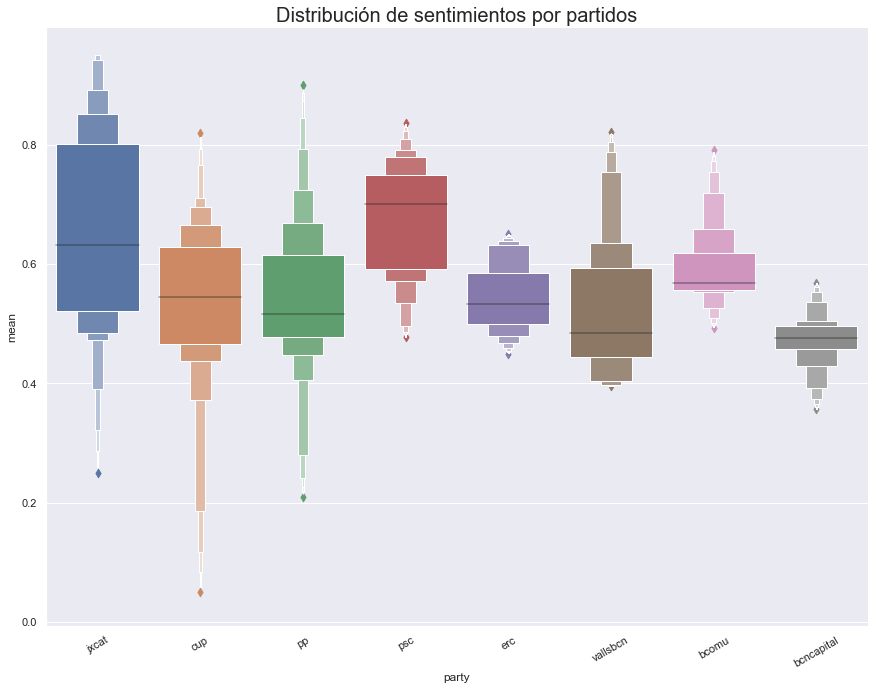

In [37]:
## Gráfica de distribución de sentimientos por partidos
x = 'created_at'
y = 'google_sentiment'
feature_color = 'party'
lista = list(np.unique(train_df_tr[feature_color]))
list_of_series = [train_df_tr[x], train_df_tr[y], train_df_tr[feature_color]]
col_names = [x,y,feature_color]
df = pd.DataFrame(list_of_series, columns=col_names)
df = pd.concat(list_of_series, axis=1)

df.created_at = pd.to_datetime(df.created_at)
df = df.groupby([pd.Grouper(key='created_at', freq='M'),
                 pd.Grouper(key='party')]).agg(['count', 'mean'])
b = df.stack(level=0).reset_index()

fg = sns.factorplot(x="party", y="mean", kind="boxen",
                     data=b)
fg.set_xticklabels(rotation=30)
fig = fg.fig; ax= fg.ax
ax.set_title("Distribución de sentimientos por partidos", fontsize=20)
fig.set_size_inches(14, 10)

Gracias a la representación de los Boxplot se pueden sacar diversas conclusiones:

1. El partido más positivo es PSC.
2. Los partidos más negativos son VallsBcn y BcnCapital.
3. Los partidos más constantes en cuanto a sentimiento son ERC y BcnCapital.
4. Los partidos con mayor volatilidad son CUP y PP, con tweets tanto muy positivos como muy negativos.


/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


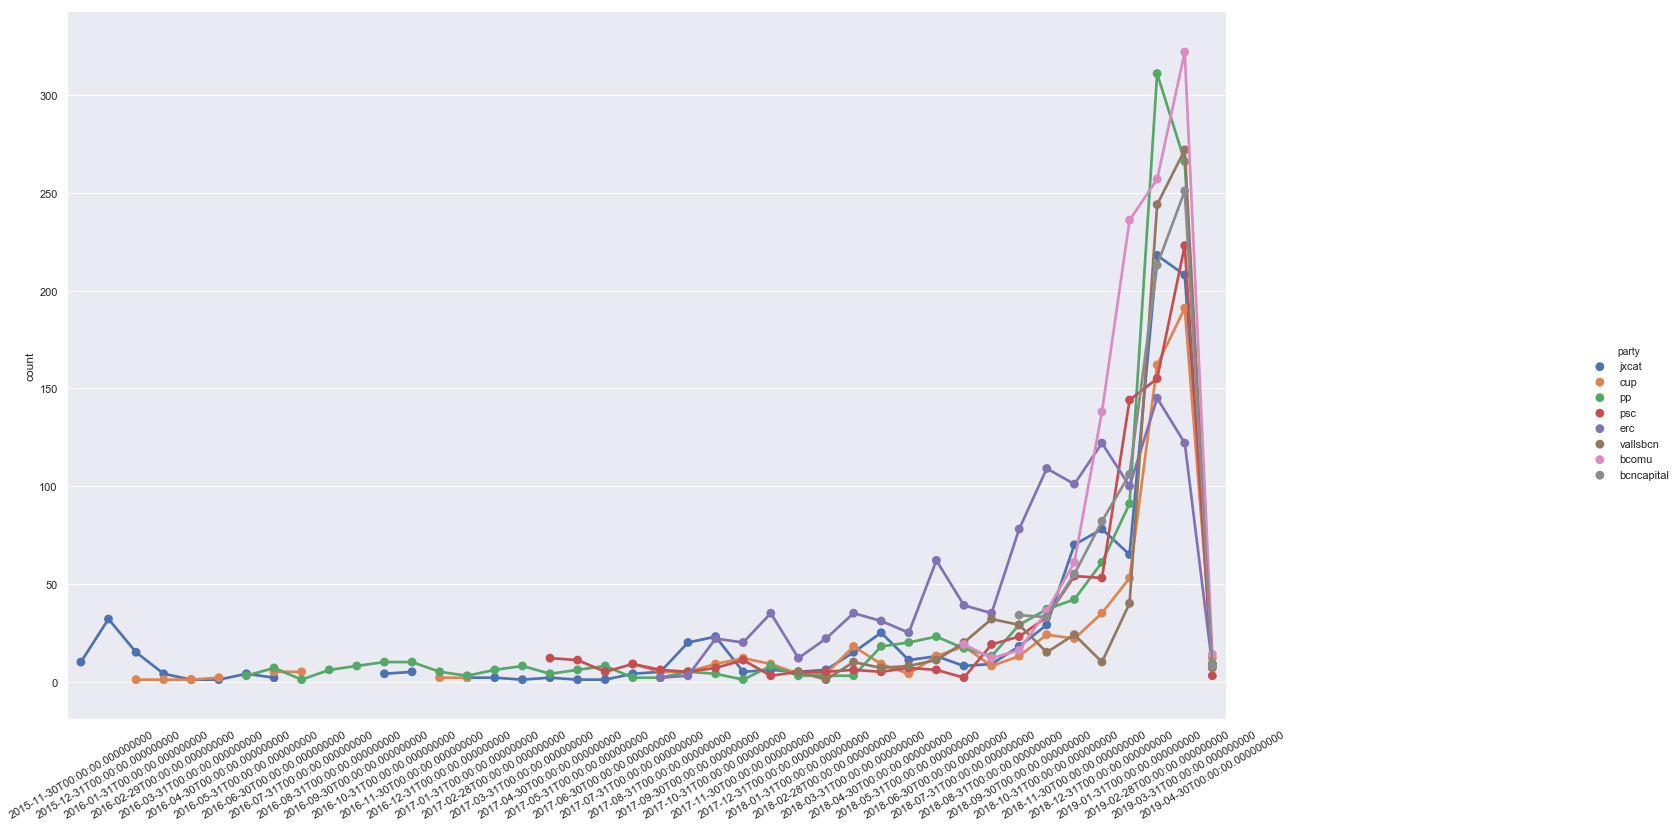

In [15]:
def create_plot5(feature1, feature2, feature_color, freq_time, tipo, tipo_aggr, transparency, ancho, largo):
    '''
    feature 1: 'created_at'
    feature 2: 'google_sentiment', 'azure_sentiment'
    freq_time = 'M', 'Y', ...
    tipo = 'point',  ...
    tipo_aggr = 'count', 'mean' .. (alguna func que previamente se haya aggr)
    transparency = 0.1, 0.2 ...
    ancho = 30,...
    largo = 12,..
    ej: create_plot5('created_at', 'google_sentiment', 'party', 'M', 'point', 0.1, 30, 12)
    '''
    x = feature1
    y = feature2
    
    list_of_series = [train_df_tr[x], train_df_tr[y], train_df_tr[feature_color]]
    col_names = [x,y,feature_color]
    df = pd.DataFrame(list_of_series, columns=col_names)
    df = pd.concat(list_of_series, axis=1)
    
    df.created_at = pd.to_datetime(df.created_at)
    df = df.groupby([pd.Grouper(key='created_at', freq=freq_time),
                     pd.Grouper(key=feature_color)]).agg(['count', 'mean'])
    
    b = df.stack(level=0).reset_index()
            
    sns.set()
    fg = sns.factorplot(x=feature1, 
                        y=tipo_aggr, 
                        hue=feature_color, 
                        data=b, kind='point',
                        plot_kws={
                                  'points_kws': {'alpha': transparency}})
    fg.set_xlabels('')
    fg.set_xticklabels(rotation=30)
    fig, ax = fg.fig, fg.ax
    fig.set_size_inches(ancho, largo)
    if tipo_aggr == 'mean':
        ax.axhline(0.5, ls='--')
    return plt.show()

create_plot5('created_at', 'google_sentiment', 'party', 'M', 'point', 'count', 0.1, 30, 12)

La frecuencia de tweets como se muestra en la figura anterior indica que la muestra de tweets sobre la que se hizo el análisis no es constante a lo largo del tiempo, concentrandose la mayoría desde inicios de 2018 hasta la fecha.

## Google vs Azure

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Text(0.5,1,'From 2018-10-01 to 2019-04-30')

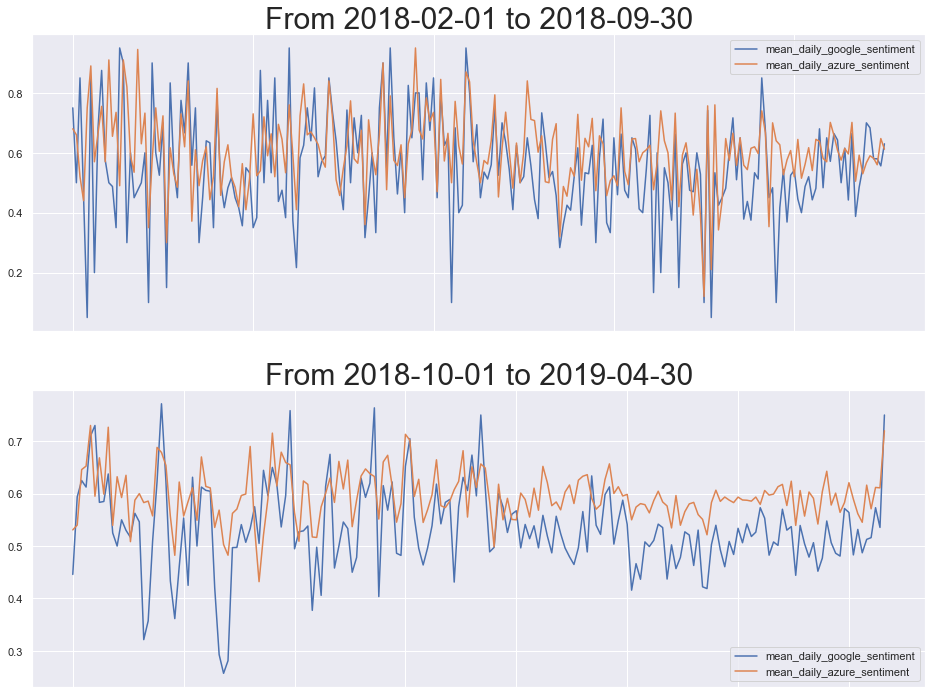

In [16]:
f = {'google_sentiment': 'mean',
     'azure_sentiment': 'mean'
     }
f_df = train_df_tr[['created_at', 'party', 'azure_sentiment', 'google_sentiment']]
f_df.created_at = pd.to_datetime(f_df.created_at)
f_df = f_df.set_index('created_at')

date1_start = '2018-02-01'
date1_end = '2018-09-30'
f_df1 = f_df.loc[date1_start:date1_end]
f_df1 = f_df1.groupby([lambda x: x.year, lambda x: x.month, lambda x: x.day]) \
    .agg(f) \
    .rename(columns={  # 'party': 'count',
    'google_sentiment': 'mean_daily_google_sentiment',
    'azure_sentiment': 'mean_daily_azure_sentiment'})

date2_start = '2018-10-01'
date2_end = '2019-04-30'
f_df2 = f_df.loc[date2_start:date2_end]
f_df2 = f_df2.groupby([lambda x: x.year, lambda x: x.month, lambda x: x.day]) \
    .agg(f) \
    .rename(columns={  # 'party': 'count',
    'google_sentiment': 'mean_daily_google_sentiment',
    'azure_sentiment': 'mean_daily_azure_sentiment'})

fig, axes = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(16, 12)
ax1 = f_df1.plot(ax=axes[0])
ax2 = f_df2.plot(ax=axes[1])
ax1.set_title('From ' + date1_start + ' to ' +  date1_end, fontsize=30)
ax2.set_title('From ' + date2_start + ' to ' +  date2_end, fontsize=30)

De las gráficas anteriores podemos observar lo siguiente: 
 - En la primera fase, hasta finales de 2018, donde el número de tweets es muy reducido por lo tanto existe volatilidad en el sentimiento diario de ambas plataformas. En la segunda fase, a partir de 2019, donde la muestra de tweets es mayor la volatilidad se reduce y las curvas se suavizan.
 - En la segunda fase se observa que si bien los sentimientos evolucionan de forma similar existe diferencia en el nivel medio de sentimiento, siendo superior el de Azure.
 - Analizando los días en los que los sentimiento decrecen notablemente se puede identificar días de sucesos destacados, por ejemplo uno de los mínimos coincide con la huelga del 21 de Febrero cuando la mayoría de partidos tweetearon mensajes muy negativos.

## Correlación entre Partidos

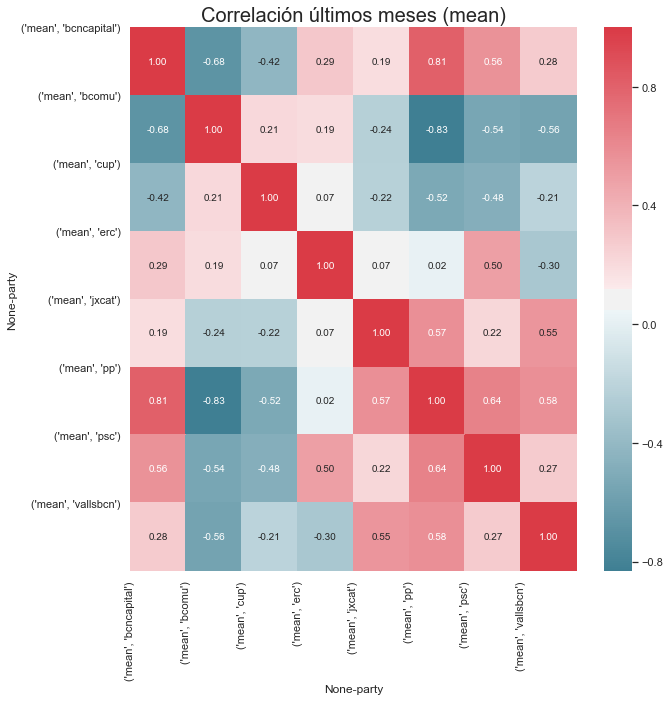

In [38]:
def heatMap(df, kind):
    
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(10, 10))
    #Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.title('Correlación últimos meses ({})'.format(kind),fontsize=20)
    plt.show()
    
    
def heatmap_full(df, sinceWhen, freq_time, sentiment, kind_agg):
    
    '''
    df: pass the train_df
    sinceWhen: '2018-09', '2017-12', etc
    freq_time: 'M', 'W-MON', ...
    sentiment: "azure_sentiment" or "google_sentiment"
    kind_agg: 'mean' or 'count'
    ej: heatmap_full(train_df_tr, '2018-09', 'M', "azure_sentiment", 'mean')
    '''       
    #Reshaping of df
    df.created_at = pd.to_datetime(df.created_at)
    df = df[df['created_at'] >= sinceWhen]
    df1 = df.groupby([pd.Grouper(key='created_at', freq=freq_time),
                 pd.Grouper(key='party')]).agg(['count', 'mean'])
    df1 = df1.stack(level=0).reset_index()
    df1_1 = df1[(df1.level_2 == sentiment)]
    df1_1 = df1_1.filter(items=['created_at','party',kind_agg])
    df1_1 = df1_1.pivot(index='created_at', columns='party')
    return heatMap(df1_1, kind_agg)

heatmap_full(train_df_tr, '2018-09', 'M', "azure_sentiment", 'mean')

Se observa que los partidos de derecha están correlacionados positivamente entre ellos y negativamente con los partidos de izquierda. 

A lo largo del tiempo estas correlaciónes se intensifican (positivos más positivos y negativos más negativos) haciendo más clara la diferencia entre los partidos de derecha e izquierda.

## CONCLUSIONES

Mediante el análisis de sentimento generalizado que ofrecen los provedores de servicios analítico en la nube se han anlizado una muestra de 7000 tweets de partidos políticos en Barcelona. 

Se han idenficado como algunos partidos tienden a escribir mensajes más positivos que otros.

Días con sucesos destacables influyen en el sentimiento de los tweets de los políticos. 

Correlación positiva entre partidos con ideologías similares.